In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/posco-aibd/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# ============================== Do not edit this shell ==========================================

# Dataset Definition

import csv
import numpy as np
import pandas as pd
import torch

from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, root, train, transform=None):
        self.train = train
        if self.train:
            root = root + 'train.csv'
        else:
            root = root + 'test.csv'
        self.csv = pd.read_csv(root, header=None)
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        if self.train:
            label = torch.tensor(self.csv.iloc[index,0], dtype=torch.long)
            img = np.array(self.csv.iloc[index,1:]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            img = np.array(self.csv.loc[index]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img
        
# ============================== Do not edit this shell ==========================================

In [3]:
# CNN import
import gc
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from IPython.display import clear_output
from skimage.transform import resize as OVResize
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchsummary import summary as Summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale

GPU will be used in training/validation.
===================== Check the data =========================

Train dataset length = 13481
Valid dataset length = 1498
Test dataset length = 3745

Content of Y (Label, type=<class 'torch.Tensor'>) = 8
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 224, 224])


/home/piai/anaconda3/envs/AIBD/lib/python3.8/site-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


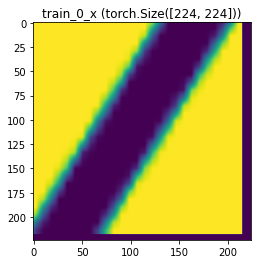

================== Check the data loader ======================

Idx: 0 / X.shape = torch.Size([16, 1, 224, 224]) / Y.shape = torch.Size([16])

Y[0:16] = tensor([8, 1, 0, 3, 6, 7, 1, 3, 3, 8, 3, 4, 0, 4, 9, 1])


In [4]:
# Library Importation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from IPython.display import clear_output
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


# Hyper Parameter
# 밝기 normalize
input_norm_mean = (.4914, .4822, .4465)
input_norm_std = (.2023, .1994, .2010)
batch_size = 16

## Model
hidden_layer = 300

## Learning
logging_dispfig = True
maximum_epoch = 4
learning_rate = 0.001


# Device Preparation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')


# Load dataset into python variable
input_transform = transforms.Compose([
    Resize(224),
    RandomCrop(224, padding=24),
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=input_norm_mean, std=input_norm_std)
])

# Prepare dataset
root = '/home/piai/AI/assignment/'
train_data = CharDataset(root, train=True, transform=input_transform)
train_data, valid_data = random_split(train_data, [round(len(train_data)*0.9), round(len(train_data)*0.1)])
test_data = CharDataset(root, train=False, transform=input_transform)

# Check the data
print('===================== Check the data =========================\n')
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')


train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()

# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

# Examine the data loader
print('================== Check the data loader ======================\n')
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label}')
preview_index = 0

In [5]:
# Model
def init_model():
    global net, loss_fn, optim
    net = MyLittleCNN().to(device)
    # net = nn.DataPallel(MyLittleCNN()).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
  
  
class MyLittleCNN(nn.Module):
    """My Little Convolutional Neural Network for Active CAM, based on VGG11""" 
    def __init__(self):
        super(MyLittleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, 4 * 4 * 50) # [batch_size, 50, 4, 4]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
#     def forward(self, data):
#         conv_out = self.convolution_part(data)
#         avg_out = self.channelavg_part(conv_out)
#         avg_out_flatten = avg_out.reshape(avg_out.size(0), -1)
#         classifier_out = self.classifier_part(avg_out_flatten)
#         return classifier_out, conv_out

        
# Model structure check
Summary(MyLittleCNN().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [6]:
# Memory cleaner to prevent CUDA out of memory error
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

In [13]:
# Epoch (similar to day 2)
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    # Clear memory to prevent CUDA memory error
    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

# Logging (same with day 2)
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1
  
  
def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)
  
    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

In [14]:
# Training Initialization (same with day 2)
init_model()
init_epoch()
init_log()

# Training Iteration (similar to day 2)
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

RuntimeError: The size of tensor a (2809) must match the size of tensor b (16) at non-singleton dimension 0

In [14]:

# Save prediction vector to CSV file

# Before run this code, here put your save path
save_root = './test_pred.csv'   # <--- only edit this path

# After run this code, you must check that the shape of 'out' variable is 3745. (out.shape == 3745)


# ============================== Do not edit under this line ==========================================
for _data in test_loader:
    data = _data.view([len(_data), -1]).to(device)

    # 1. Feed-forward
    onehot_out = net(data)
    _, out = torch.max(onehot_out, 1)
    
print(out.shape)

import csv

if os.path.lsfile(save.root):
    os.remove(save_root)

for idx, pred in enumerate(list(out.cpu())):
    with open(save_root, 'a', newline='') as f:
        writer = csv.writer(f)
        if idx == 0:
            writer.writerow(['id', 'label'])
        pred = np.concatenate(([idx], [pred]))
        writer.writerow(pred)
# ============================== Do not edit over this line ==========================================

torch.Size([3745])


AttributeError: module 'posixpath' has no attribute 'lsfile'